In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, GRU, SpatialDropout1D, Bidirectional, MaxPooling1D, Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import spacy
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
spacy.require_gpu()
import scikitplot as skplt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
import string

# Load the training and testing data

In [ ]:
processed_directory = '../processed_data/'
train_df = pd.read_csv('../processed_data/train.json')
test_df = pd.read_json('../processed_data/test.json')

In [20]:
train_x = pd.read_csv('./x_train.csv')
train_y = pd.read_csv('./y_train.csv')
test_x = pd.read_csv('./x_test.csv')
test_y = pd.read_csv('./y_test.csv')
train_df = pd.concat([train_x, train_y], axis=1)
test_df = pd.concat([test_x, test_y], axis=1)

In [21]:
train_df = train_df[['text', 'label']]
train_df

,text,label
0,bromwell high cartoon comedy ran time program ...,+
1,homelessness houselessness george carlin state...,+
2,brilliant overacting lesley ann warren best dr...,+
3,easily underrated film inn brook cannon sure f...,+
4,typical mel brook film much le slapstick movie...,+
...,...,...
24995,towards end movie felt technical felt like cla...,-
24996,kind movie enemy content watch time bloody tru...,-
24997,saw descent last night stockholm film festival...,-
24998,film pick pound turn rather good 23rd century ...,-


In [22]:
train_df = train_df.sample(len(train_df), random_state=42)
train_df.reset_index(inplace=True, drop=True)
train_df

,text,label
0,panic street richard widmark play u navy docto...,+
1,ask first one really better one look sarah g r...,-
2,big fan faerie tale theatre ive seen one best ...,+
3,finished reading book dillinger movie horribly...,-
4,greg davis bryan daly take crazed statement te...,-
...,...,...
24995,roommate nearly shorted tv numerous spittakes ...,-
24996,michelle rodriguez defining actress could char...,+
24997,nice movie great soundtrack span rock landscap...,+
24998,even though madefortv production there absolut...,-


In [5]:
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Doing a bit of checking

In [23]:
def get_len(s):
    return len(s.split())
len_df_train = train_df['text'].progress_apply(get_len)
len_df_test = test_df['text'].progress_apply(get_len)


100%|██████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 223007.80it/s]


count    25000.000000
mean       124.186080
std         93.508967
min          4.000000
25%         66.000000
50%         92.000000
75%        151.000000
max       1449.000000
Name: text, dtype: float64

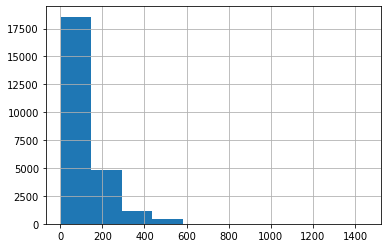

In [28]:
len_df_train.hist()
len_df_train.describe()

count    25000.000000
mean       121.364840
std         91.139747
min          3.000000
25%         65.000000
50%         90.000000
75%        147.000000
max       1191.000000
Name: text, dtype: float64

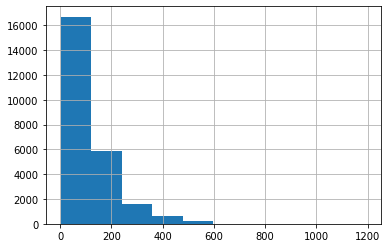

In [29]:
len_df_test.hist()
len_df_test.describe()

# Storing some variables

In [27]:
train_len = int(0.8*len(train_df))
max_words=250
embedding_size=300


In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'].values)

In [31]:
def one_hot(row):
    if row == '-':
        return [1, 0]
    else:
        return [0, 1]
    
    
def get_features(df):
    sequences = tokenizer.texts_to_sequences(df['text'].values)
    x = pad_sequences(sequences, maxlen=max_words)
    y = df['label'].apply(one_hot).tolist()
    y = np.array(y)
    return x, y

def get_one_hot(df):
    y = df.apply(one_hot).tolist()
    return np.array(y)

In [32]:
train_val_x, train_val_y = get_features(train_df)
test_x, test_y = get_features(test_df)

In [33]:
train_x, val_x = train_val_x[:train_len], train_val_x[train_len:]
train_y, val_y = train_val_y[:train_len], train_val_y[train_len:]

In [34]:
def predict_result(model, x, y_true):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)
    skplt.metrics.plot_confusion_matrix(y_true, y_pred)
    print(f'f1 : {f1_score(y_true, y_pred)}')
    print(f'acc: {accuracy_score(y_true, y_pred)}')    

## RNN with LSTM

In [50]:
model = Sequential([
    Embedding(300, embedding_size, input_length=max_words),
    SpatialDropout1D(0.4),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_lstm2_fatin/checkpoint',
                   save_best_only=True, verbose=1, monitor='val_accuracy')
]
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 300)          90000     
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 250, 300)         0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 64)                93440     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                      

In [51]:
model.compile(loss='categorical_crossentropy', 
             optimizer=SGD(momentum=0.02), 
             metrics=['accuracy'])

In [53]:
model.fit(train_x, train_y, 
          epochs=100,
         callbacks=callbacks,
         validation_data=(val_x, val_y),
         batch_size=256)

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.7105
Epoch 1: val_accuracy did not improve from 0.74060
79/79 [==============================] - 2s 26ms/step - loss: 0.5653 - accuracy: 0.7105 - val_loss: 0.6647 - val_accuracy: 0.6154
Epoch 2/100
78/79 [============================>.] - ETA: 0s - loss: 0.5654 - accuracy: 0.7057
Epoch 2: val_accuracy improved from 0.74060 to 0.75500, saving model to ./models_lstm2_fatin\checkpoint


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 50ms/step - loss: 0.5653 - accuracy: 0.7058 - val_loss: 0.5117 - val_accuracy: 0.7550
Epoch 3/100
78/79 [============================>.] - ETA: 0s - loss: 0.5618 - accuracy: 0.7140
Epoch 3: val_accuracy did not improve from 0.75500
79/79 [==============================] - 2s 27ms/step - loss: 0.5619 - accuracy: 0.7139 - val_loss: 0.5177 - val_accuracy: 0.7530
Epoch 4/100
77/79 [============================>.] - ETA: 0s - loss: 0.5572 - accuracy: 0.7177
Epoch 4: val_accuracy did not improve from 0.75500
79/79 [==============================] - 2s 26ms/step - loss: 0.5568 - accuracy: 0.7178 - val_loss: 0.6401 - val_accuracy: 0.6286
Epoch 5/100
78/79 [============================>.] - ETA: 0s - loss: 0.5552 - accuracy: 0.7210
Epoch 5: val_accuracy did not improve from 0.75500
79/79 [==============================] - 2s 26ms/step - loss: 0.5550 - accuracy: 0.7211 - val_loss: 0.5112 - val_accuracy: 0.7516
Epoch 6/100
78/79 [=======================

INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 49ms/step - loss: 0.5420 - accuracy: 0.7290 - val_loss: 0.5049 - val_accuracy: 0.7618
Epoch 12/100
79/79 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.7295
Epoch 12: val_accuracy did not improve from 0.76180
79/79 [==============================] - 2s 25ms/step - loss: 0.5413 - accuracy: 0.7295 - val_loss: 0.5016 - val_accuracy: 0.7616
Epoch 13/100
77/79 [============================>.] - ETA: 0s - loss: 0.5358 - accuracy: 0.7341
Epoch 13: val_accuracy did not improve from 0.76180
79/79 [==============================] - 2s 24ms/step - loss: 0.5364 - accuracy: 0.7329 - val_loss: 0.5349 - val_accuracy: 0.7254
Epoch 14/100
77/79 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.7410
Epoch 14: val_accuracy did not improve from 0.76180
79/79 [==============================] - 2s 25ms/step - loss: 0.5285 - accuracy: 0.7412 - val_loss: 0.7687 - val_accuracy: 0.5960
Epoch 15/100
78/79 [================

INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 54ms/step - loss: 0.5302 - accuracy: 0.7426 - val_loss: 0.4888 - val_accuracy: 0.7732
Epoch 16/100
77/79 [============================>.] - ETA: 0s - loss: 0.5352 - accuracy: 0.7380
Epoch 16: val_accuracy did not improve from 0.77320
79/79 [==============================] - 2s 26ms/step - loss: 0.5351 - accuracy: 0.7382 - val_loss: 0.7543 - val_accuracy: 0.5742
Epoch 17/100
78/79 [============================>.] - ETA: 0s - loss: 0.5314 - accuracy: 0.7403
Epoch 17: val_accuracy did not improve from 0.77320
79/79 [==============================] - 2s 24ms/step - loss: 0.5313 - accuracy: 0.7404 - val_loss: 0.5044 - val_accuracy: 0.7522
Epoch 18/100
77/79 [============================>.] - ETA: 0s - loss: 0.5236 - accuracy: 0.7449
Epoch 18: val_accuracy did not improve from 0.77320
79/79 [==============================] - 2s 23ms/step - loss: 0.5227 - accuracy: 0.7458 - val_loss: 0.5481 - val_accuracy: 0.7388
Epoch 19/100
79/79 [================

INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 48ms/step - loss: 0.5291 - accuracy: 0.7372 - val_loss: 0.4951 - val_accuracy: 0.7736
Epoch 21/100
77/79 [============================>.] - ETA: 0s - loss: 0.5182 - accuracy: 0.7488
Epoch 21: val_accuracy did not improve from 0.77360
79/79 [==============================] - 2s 24ms/step - loss: 0.5175 - accuracy: 0.7493 - val_loss: 0.4964 - val_accuracy: 0.7602
Epoch 22/100
79/79 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.7495
Epoch 22: val_accuracy did not improve from 0.77360
79/79 [==============================] - 2s 23ms/step - loss: 0.5184 - accuracy: 0.7495 - val_loss: 0.5878 - val_accuracy: 0.6806
Epoch 23/100
79/79 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7474
Epoch 23: val_accuracy did not improve from 0.77360
79/79 [==============================] - 2s 23ms/step - loss: 0.5194 - accuracy: 0.7474 - val_loss: 0.5004 - val_accuracy: 0.7626
Epoch 24/100
79/79 [================

INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 50ms/step - loss: 0.5102 - accuracy: 0.7563 - val_loss: 0.4654 - val_accuracy: 0.7864
Epoch 30/100
78/79 [============================>.] - ETA: 0s - loss: 0.5061 - accuracy: 0.7581
Epoch 30: val_accuracy improved from 0.78640 to 0.78700, saving model to ./models_lstm2_fatin\checkpoint


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 50ms/step - loss: 0.5061 - accuracy: 0.7581 - val_loss: 0.4659 - val_accuracy: 0.7870
Epoch 31/100
77/79 [============================>.] - ETA: 0s - loss: 0.5078 - accuracy: 0.7600
Epoch 31: val_accuracy did not improve from 0.78700
79/79 [==============================] - 2s 27ms/step - loss: 0.5077 - accuracy: 0.7602 - val_loss: 0.4654 - val_accuracy: 0.7836
Epoch 32/100
79/79 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.7633
Epoch 32: val_accuracy did not improve from 0.78700
79/79 [==============================] - 2s 26ms/step - loss: 0.5010 - accuracy: 0.7633 - val_loss: 0.8737 - val_accuracy: 0.5500
Epoch 33/100
77/79 [============================>.] - ETA: 0s - loss: 0.5005 - accuracy: 0.7641
Epoch 33: val_accuracy did not improve from 0.78700
79/79 [==============================] - 2s 26ms/step - loss: 0.4997 - accuracy: 0.7649 - val_loss: 0.9500 - val_accuracy: 0.5658
Epoch 34/100
78/79 [================

79/79 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.7826
Epoch 60: val_accuracy did not improve from 0.78700
79/79 [==============================] - 2s 24ms/step - loss: 0.4711 - accuracy: 0.7826 - val_loss: 0.4638 - val_accuracy: 0.7844
Epoch 61/100
79/79 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.7810
Epoch 61: val_accuracy did not improve from 0.78700
79/79 [==============================] - 2s 24ms/step - loss: 0.4718 - accuracy: 0.7810 - val_loss: 0.4836 - val_accuracy: 0.7670
Epoch 62/100
79/79 [==============================] - ETA: 0s - loss: 0.4670 - accuracy: 0.7844
Epoch 62: val_accuracy improved from 0.78700 to 0.79400, saving model to ./models_lstm2_fatin\checkpoint


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 56ms/step - loss: 0.4670 - accuracy: 0.7844 - val_loss: 0.4455 - val_accuracy: 0.7940
Epoch 63/100
79/79 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.7829
Epoch 63: val_accuracy did not improve from 0.79400
79/79 [==============================] - 2s 26ms/step - loss: 0.4681 - accuracy: 0.7829 - val_loss: 0.6685 - val_accuracy: 0.6532
Epoch 64/100
79/79 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.7832
Epoch 64: val_accuracy did not improve from 0.79400
79/79 [==============================] - 2s 24ms/step - loss: 0.4654 - accuracy: 0.7832 - val_loss: 0.4722 - val_accuracy: 0.7798
Epoch 65/100
78/79 [============================>.] - ETA: 0s - loss: 0.4688 - accuracy: 0.7802
Epoch 65: val_accuracy did not improve from 0.79400
79/79 [==============================] - 2s 24ms/step - loss: 0.4688 - accuracy: 0.7803 - val_loss: 0.5985 - val_accuracy: 0.6904
Epoch 66/100
77/79 [================

INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 51ms/step - loss: 0.4624 - accuracy: 0.7872 - val_loss: 0.4448 - val_accuracy: 0.7962
Epoch 71/100
78/79 [============================>.] - ETA: 0s - loss: 0.4611 - accuracy: 0.7875
Epoch 71: val_accuracy did not improve from 0.79620
79/79 [==============================] - 2s 27ms/step - loss: 0.4610 - accuracy: 0.7875 - val_loss: 0.5800 - val_accuracy: 0.7168
Epoch 72/100
79/79 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.7867
Epoch 72: val_accuracy did not improve from 0.79620
79/79 [==============================] - 2s 26ms/step - loss: 0.4651 - accuracy: 0.7867 - val_loss: 0.4458 - val_accuracy: 0.7924
Epoch 73/100
77/79 [============================>.] - ETA: 0s - loss: 0.4643 - accuracy: 0.7838
Epoch 73: val_accuracy improved from 0.79620 to 0.79640, saving model to ./models_lstm2_fatin\checkpoint


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 51ms/step - loss: 0.4637 - accuracy: 0.7841 - val_loss: 0.4428 - val_accuracy: 0.7964
Epoch 74/100
77/79 [============================>.] - ETA: 0s - loss: 0.4674 - accuracy: 0.7826
Epoch 74: val_accuracy did not improve from 0.79640
79/79 [==============================] - 2s 27ms/step - loss: 0.4669 - accuracy: 0.7829 - val_loss: 0.5179 - val_accuracy: 0.7466
Epoch 75/100
78/79 [============================>.] - ETA: 0s - loss: 0.4659 - accuracy: 0.7834
Epoch 75: val_accuracy did not improve from 0.79640
79/79 [==============================] - 2s 25ms/step - loss: 0.4660 - accuracy: 0.7833 - val_loss: 0.6464 - val_accuracy: 0.6770
Epoch 76/100
77/79 [============================>.] - ETA: 0s - loss: 0.4669 - accuracy: 0.7843
Epoch 76: val_accuracy did not improve from 0.79640
79/79 [==============================] - 2s 26ms/step - loss: 0.4664 - accuracy: 0.7843 - val_loss: 0.5775 - val_accuracy: 0.7114
Epoch 77/100
78/79 [================

INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 56ms/step - loss: 0.4576 - accuracy: 0.7885 - val_loss: 0.4410 - val_accuracy: 0.7970
Epoch 83/100
78/79 [============================>.] - ETA: 0s - loss: 0.4548 - accuracy: 0.7878
Epoch 83: val_accuracy did not improve from 0.79700
79/79 [==============================] - 2s 25ms/step - loss: 0.4550 - accuracy: 0.7876 - val_loss: 0.5148 - val_accuracy: 0.7466
Epoch 84/100
78/79 [============================>.] - ETA: 0s - loss: 0.4561 - accuracy: 0.7901
Epoch 84: val_accuracy did not improve from 0.79700
79/79 [==============================] - 2s 24ms/step - loss: 0.4564 - accuracy: 0.7900 - val_loss: 0.4642 - val_accuracy: 0.7808
Epoch 85/100
78/79 [============================>.] - ETA: 0s - loss: 0.4532 - accuracy: 0.7922
Epoch 85: val_accuracy improved from 0.79700 to 0.79940, saving model to ./models_lstm2_fatin\checkpoint


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_lstm2_fatin\checkpoint\assets


79/79 [==============================] - 4s 50ms/step - loss: 0.4533 - accuracy: 0.7919 - val_loss: 0.4378 - val_accuracy: 0.7994
Epoch 86/100
77/79 [============================>.] - ETA: 0s - loss: 0.4592 - accuracy: 0.7880
Epoch 86: val_accuracy did not improve from 0.79940
79/79 [==============================] - 2s 24ms/step - loss: 0.4596 - accuracy: 0.7875 - val_loss: 0.4499 - val_accuracy: 0.7882
Epoch 87/100
79/79 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.7903
Epoch 87: val_accuracy did not improve from 0.79940
79/79 [==============================] - 2s 23ms/step - loss: 0.4539 - accuracy: 0.7903 - val_loss: 0.5199 - val_accuracy: 0.7654
Epoch 88/100
79/79 [==============================] - ETA: 0s - loss: 0.4625 - accuracy: 0.7862
Epoch 88: val_accuracy did not improve from 0.79940
79/79 [==============================] - 2s 23ms/step - loss: 0.4625 - accuracy: 0.7862 - val_loss: 0.4850 - val_accuracy: 0.7682
Epoch 89/100
79/79 [================

In [34]:
model = load_model('./models_lstm2/checkpoint')

f1 : 0.884313725490196
acc: 0.882


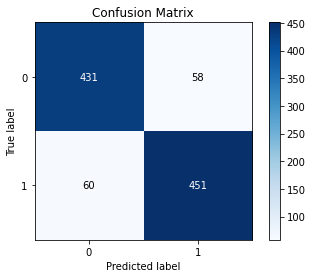

In [35]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8277618335421804
acc: 0.82956


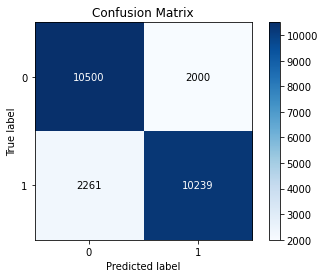

In [36]:
predict_result(model, test_x, test_y)

# RNN with GRU

In [94]:
model = Sequential([
    Embedding(600, embedding_size, input_length=max_words),
    SpatialDropout1D(0.4),
    GRU(256),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_gru/checkpoint',
                   save_best_only=True, verbose=1, monitor='val_accuracy')
]
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 500, 300)          180000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 500, 300)         0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 256)               428544    
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 2)                 514       
                                                      

In [95]:
model.compile(loss='categorical_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [96]:
model.fit(train_x, train_y, 
          epochs=50,
         callbacks=callbacks,
         validation_data=(val_x, val_y),
         batch_size=256)

Epoch 1/50
79/79 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.6481
Epoch 1: val_accuracy improved from -inf to 0.81700, saving model to ./models_gru\checkpoint
INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


79/79 [==============================] - 170s 2s/step - loss: 0.6116 - accuracy: 0.6481 - val_loss: 0.4178 - val_accuracy: 0.8170
Epoch 2/50
79/79 [==============================] - ETA: 0s - loss: 0.5599 - accuracy: 0.7099
Epoch 2: val_accuracy did not improve from 0.81700
79/79 [==============================] - 162s 2s/step - loss: 0.5599 - accuracy: 0.7099 - val_loss: 0.6189 - val_accuracy: 0.6246
Epoch 3/50
79/79 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.7062
Epoch 3: val_accuracy did not improve from 0.81700
79/79 [==============================] - 163s 2s/step - loss: 0.5551 - accuracy: 0.7062 - val_loss: 0.4987 - val_accuracy: 0.7656
Epoch 4/50
79/79 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8183
Epoch 4: val_accuracy improved from 0.81700 to 0.83840, saving model to ./models_gru\checkpoint
INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


79/79 [==============================] - 167s 2s/step - loss: 0.4065 - accuracy: 0.8183 - val_loss: 0.3722 - val_accuracy: 0.8384
Epoch 5/50
79/79 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8428
Epoch 5: val_accuracy improved from 0.83840 to 0.84400, saving model to ./models_gru\checkpoint
INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


79/79 [==============================] - 159s 2s/step - loss: 0.3604 - accuracy: 0.8428 - val_loss: 0.3768 - val_accuracy: 0.8440
Epoch 6/50
79/79 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8572
Epoch 6: val_accuracy improved from 0.84400 to 0.85600, saving model to ./models_gru\checkpoint
INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


79/79 [==============================] - 154s 2s/step - loss: 0.3318 - accuracy: 0.8572 - val_loss: 0.3423 - val_accuracy: 0.8560
Epoch 7/50
79/79 [==============================] - ETA: 0s - loss: 0.3254 - accuracy: 0.8606
Epoch 7: val_accuracy improved from 0.85600 to 0.85960, saving model to ./models_gru\checkpoint
INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


79/79 [==============================] - 153s 2s/step - loss: 0.3254 - accuracy: 0.8606 - val_loss: 0.3354 - val_accuracy: 0.8596
Epoch 8/50
79/79 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.8727
Epoch 8: val_accuracy did not improve from 0.85960
79/79 [==============================] - 151s 2s/step - loss: 0.3050 - accuracy: 0.8727 - val_loss: 0.3745 - val_accuracy: 0.8544
Epoch 9/50
79/79 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.8764
Epoch 9: val_accuracy improved from 0.85960 to 0.86300, saving model to ./models_gru\checkpoint
INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


79/79 [==============================] - 159s 2s/step - loss: 0.2957 - accuracy: 0.8764 - val_loss: 0.3312 - val_accuracy: 0.8630
Epoch 10/50
79/79 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8796
Epoch 10: val_accuracy did not improve from 0.86300
79/79 [==============================] - 149s 2s/step - loss: 0.2850 - accuracy: 0.8796 - val_loss: 0.3656 - val_accuracy: 0.8398
Epoch 11/50
79/79 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.8824
Epoch 11: val_accuracy did not improve from 0.86300
79/79 [==============================] - 152s 2s/step - loss: 0.2803 - accuracy: 0.8824 - val_loss: 0.3647 - val_accuracy: 0.8452
Epoch 12/50
79/79 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.8878
Epoch 12: val_accuracy did not improve from 0.86300
79/79 [==============================] - 151s 2s/step - loss: 0.2696 - accuracy: 0.8878 - val_loss: 0.3331 - val_accuracy: 0.8584
Epoch 13/50
79/79 [====================

INFO:tensorflow:Assets written to: ./models_gru\checkpoint\assets


79/79 [==============================] - 155s 2s/step - loss: 0.2445 - accuracy: 0.8978 - val_loss: 0.3402 - val_accuracy: 0.8652
Epoch 17/50
79/79 [==============================] - ETA: 0s - loss: 0.2344 - accuracy: 0.9039
Epoch 17: val_accuracy did not improve from 0.86520
79/79 [==============================] - 163s 2s/step - loss: 0.2344 - accuracy: 0.9039 - val_loss: 0.3448 - val_accuracy: 0.8610
Epoch 18/50
79/79 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9053
Epoch 18: val_accuracy did not improve from 0.86520
79/79 [==============================] - 163s 2s/step - loss: 0.2310 - accuracy: 0.9053 - val_loss: 0.3971 - val_accuracy: 0.8614
Epoch 19/50
79/79 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9067
Epoch 19: val_accuracy did not improve from 0.86520
79/79 [==============================] - 167s 2s/step - loss: 0.2272 - accuracy: 0.9067 - val_loss: 0.4213 - val_accuracy: 0.8392
Epoch 20/50
79/79 [====================

In [59]:
model = load_model('./models_bilstm2/checkpoint')

f1 : 0.9045801526717556
acc: 0.9


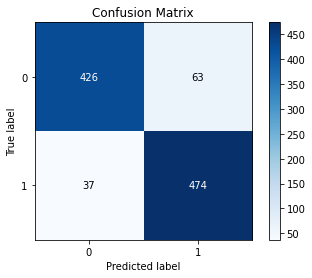

In [60]:
predict_result(model, train_x[:1000], train_y[:1000])

f1 : 0.8414049815863461
acc: 0.8398


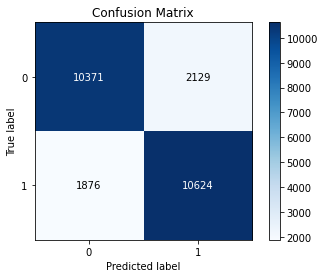

In [61]:
predict_result(model, test_x, test_y)

# RNN with Bidirectional LSTM

In [54]:
model = Sequential([
    Embedding(600, embedding_size, input_length=max_words),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='sigmoid')
])

callbacks=[
    ModelCheckpoint(filepath='./models_bilstm2/checkpoint',
                   save_best_only=True, verbose=1, monitor='val_loss')
]
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 300)          180000    
                                                                 
 bidirectional (Bidirectiona  (None, 250, 512)         1140736   
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 250, 512)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              295424    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [57]:
model.compile(loss='categorical_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [58]:
model.fit(train_x, train_y, 
          epochs=50,
         callbacks=callbacks,
         validation_data=(val_x, val_y),
         batch_size=128)

Epoch 1/50
157/157 [==============================] - ETA: 0s - loss: 0.5058 - accuracy: 0.7495
Epoch 1: val_loss improved from inf to 0.42455, saving model to ./models_bilstm2\checkpoint


INFO:tensorflow:Assets written to: ./models_bilstm2\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_bilstm2\checkpoint\assets


157/157 [==============================] - 27s 152ms/step - loss: 0.5058 - accuracy: 0.7495 - val_loss: 0.4245 - val_accuracy: 0.8188
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.8236
Epoch 2: val_loss did not improve from 0.42455
157/157 [==============================] - 13s 85ms/step - loss: 0.4105 - accuracy: 0.8236 - val_loss: 0.5146 - val_accuracy: 0.7618
Epoch 3/50
157/157 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8349
Epoch 3: val_loss improved from 0.42455 to 0.41039, saving model to ./models_bilstm2\checkpoint


INFO:tensorflow:Assets written to: ./models_bilstm2\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_bilstm2\checkpoint\assets


157/157 [==============================] - 24s 151ms/step - loss: 0.3895 - accuracy: 0.8349 - val_loss: 0.4104 - val_accuracy: 0.8186
Epoch 4/50
157/157 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8460
Epoch 4: val_loss improved from 0.41039 to 0.39826, saving model to ./models_bilstm2\checkpoint


INFO:tensorflow:Assets written to: ./models_bilstm2\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_bilstm2\checkpoint\assets


157/157 [==============================] - 24s 153ms/step - loss: 0.3654 - accuracy: 0.8460 - val_loss: 0.3983 - val_accuracy: 0.8256
Epoch 5/50
157/157 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.8503
Epoch 5: val_loss improved from 0.39826 to 0.39803, saving model to ./models_bilstm2\checkpoint


INFO:tensorflow:Assets written to: ./models_bilstm2\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_bilstm2\checkpoint\assets


157/157 [==============================] - 23s 149ms/step - loss: 0.3556 - accuracy: 0.8503 - val_loss: 0.3980 - val_accuracy: 0.8214
Epoch 6/50
157/157 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.8601
Epoch 6: val_loss did not improve from 0.39803
157/157 [==============================] - 13s 80ms/step - loss: 0.3379 - accuracy: 0.8601 - val_loss: 0.3999 - val_accuracy: 0.8198
Epoch 7/50
157/157 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.8607
Epoch 7: val_loss did not improve from 0.39803
157/157 [==============================] - 12s 80ms/step - loss: 0.3311 - accuracy: 0.8607 - val_loss: 0.4109 - val_accuracy: 0.8236
Epoch 8/50
157/157 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.8643
Epoch 8: val_loss improved from 0.39803 to 0.38927, saving model to ./models_bilstm2\checkpoint


INFO:tensorflow:Assets written to: ./models_bilstm2\checkpoint\assets


INFO:tensorflow:Assets written to: ./models_bilstm2\checkpoint\assets


157/157 [==============================] - 24s 150ms/step - loss: 0.3252 - accuracy: 0.8643 - val_loss: 0.3893 - val_accuracy: 0.8332
Epoch 9/50
157/157 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.8732
Epoch 9: val_loss did not improve from 0.38927
157/157 [==============================] - 13s 84ms/step - loss: 0.3069 - accuracy: 0.8732 - val_loss: 0.4006 - val_accuracy: 0.8200
Epoch 10/50
157/157 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.8765
Epoch 10: val_loss did not improve from 0.38927
157/157 [==============================] - 13s 85ms/step - loss: 0.3026 - accuracy: 0.8765 - val_loss: 0.4208 - val_accuracy: 0.8254
Epoch 11/50
157/157 [==============================] - ETA: 0s - loss: 0.2972 - accuracy: 0.8773
Epoch 11: val_loss did not improve from 0.38927
157/157 [==============================] - 13s 84ms/step - loss: 0.2972 - accuracy: 0.8773 - val_loss: 0.4272 - val_accuracy: 0.8202
Epoch 12/50
157/157 [=============

Epoch 38/50
157/157 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9855
Epoch 38: val_loss did not improve from 0.38927
157/157 [==============================] - 13s 83ms/step - loss: 0.0442 - accuracy: 0.9855 - val_loss: 1.0807 - val_accuracy: 0.8062
Epoch 39/50
157/157 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9875
Epoch 39: val_loss did not improve from 0.38927
157/157 [==============================] - 13s 84ms/step - loss: 0.0382 - accuracy: 0.9875 - val_loss: 1.0655 - val_accuracy: 0.8022
Epoch 40/50
157/157 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9839
Epoch 40: val_loss did not improve from 0.38927
157/157 [==============================] - 13s 84ms/step - loss: 0.0542 - accuracy: 0.9839 - val_loss: 0.9991 - val_accuracy: 0.7828
Epoch 41/50
157/157 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9773
Epoch 41: val_loss did not improve from 0.38927
157/157 [============